## Introduction to geocoding and plotting using HTRC Analytics, Geopy and Cartopy


In this notebook, the goal is to introduce you to geolocation and plotting locations generated from Named Entity Recognition (NER) using Python, HathiTrust data and HathiTrust Research Center (HTRC) tools. The main focus will be to take the output of [HTRC's built-in Named Entity Recognizer ](https://analytics.hathitrust.org/statisticalalgorithms) algorithm run over a workset, and use it to geocode and plot locations. The NER algorithm's output is very useful for this, as it does the NER step and tagging for you, without any need for code. However, should you be interested, at the end of the notebook, there is a further section on recreating the NER steps over full text data directly using the [Natural Language Toolkit (NLTK)](https://www.nltk.org/). This notebook will help you:

1. Load the output CSV of the NER algorithm in HTRC Analytics into a [Pandas](https://pandas.pydata.org/) DataFrame and extract locations;
2. Use the library [GeoPy](https://geopy.readthedocs.io/en/stable/) to geocode each location; and
3. Use a mapping library, [Cartopy](https://scitools.org.uk/cartopy/docs/latest/), to plot geographic data using MatPlotLib.

If you're using Anaconda to manage your python packages, the Natural Language Toolkit (NLTK), Cartopy, Matplotlib and Pandas should already be installed. You can test this by skipping to our first code cell and seeing if the libraries import correctly. Instructions for installing these packages and Geopy using `pip` are below.

NLTK, GeoPy, Matplotlib and Pandas can be downloaded and installed using `pip`, as so:

`pip install geopy`

`pip install pandas`

`pip install matplotlib`

`pip install nltk`

`pip install cartopy`

If you're using Anaconda but do not have certain packages installed, it's recommended to download and install using `conda` instead of `pip` as it will ensure that the correct version and dependencies are also installed:

`conda install -c conda-forge cartopy`

`conda install -c conda-forge matplotlib`

`conda install -c conda-forge geopy`

`conda install nltk`

`conda install pandas`

Now that we are all setup, we can start on this project. First, there are some libraries we must import into this notebook in order to use them later:

In [1]:
import geopy, time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd

## Importing NER data from HTRC Analytics

Now, let's load in the result of our NER algorithm run in HTRC Analytics: a CSV of entities, the volume and page of their appearance, and their entity type. We'll import this as a Pandas DataFrame, as it is already in CSV form:

In [2]:
entities = open('/Users/rdubnic2/Desktop/entities.csv','r')
ent_df = pd.read_csv(entities)

print(ent_df.shape)
ent_df.head()

(339552, 4)


,vol_id,page_seq,entity,type
0,mdp.39015073487137,1,Walter Paget,PERSON
1,mdp.39015073487137,1,Alfred Henty,PERSON
2,mdp.39015073487137,7,AGINCOURT,LOCATION
3,mdp.39015073487137,11,CHARI,ORGANIZATION
4,mdp.39015073487137,13,Bartholomew,PERSON


Here we see that the CSV was loaded correctly and get to see what our data looks like. Our entities are tagged with strings in the `type` column, so we need to go through our data and pull out the entities that are tagged as "LOCATION" in this colummn. If we want to be inclusive, with small adjustments to our code we could also pull out other types, such as "ORGANIZATION" in the interest of not losing any positives. However, we'll focus just on locations today.

## Extracting and geocoding locations from our entities CSV
   To extract only the entities tagged as locations in this file, we can simply use a `for` loop and the Pandas method `.iterrows()` which will let us use the index of the DataFrame to loop through the data, but still individually call any columns in which we're interested. Here, we want to extract the entity name for each entity with the value `LOCATION` in the `type` column. Eventually, we'll end with a new list of only place names (`place_list`):

In [3]:
place_list = []

for i, r in ent_df.iterrows():
    name = r['entity']
    ner_type = r['type']
    if ner_type == 'LOCATION':
        place_list.append(name)
    else:
        continue
        
print(f"Found {len(place_list)} locations.")

Found 37842 locations.


Geopy allows for a number of different types of geocoders to be initialized and called, such as Google Maps, Bing Maps, Nominatim, etc. Each may have different requirements for their use, however, such as Google Maps, which requires an API key. In order to avoid this, we'll use Nominatim, which doesn't require a key and is built on the [OpenStreetMap](https://www.openstreetmap.org) data, which is crowdsourced, open and free:

In [4]:
api = geopy.geocoders.Nominatim(user_agent="my-application") # initializing Nominatim as our geocoding engine.
    
result, (lat, lng) = api.geocode("1600 Pennsylvania Ave NW, Washington D.C.")
print(result)
print(lat, lng)

White House, 1600, Pennsylvania Avenue Northwest, Golden Triangle, Washington, D.C., 20500, USA
38.8976998 -77.0365534886228


Here, we've initialized our geocoder object using Nominatim, and for easier referencing later, named it `api`. We can now use all of the built-in methods that geopy has for geocoders by only calling api + the method syntax.

Just to ensure things are working, I've also included a test geocode: the address for the White House, which it correctly finds. You'll notice three variables are being retrieved from the geocode: 

* `result`: the place name of the geolocation
* `lat`: the latitude for the geolocation
* `lng`: the longitude for the geolocation

This syntax is handy, as it also assigns the output from the geocoder to variables (`result`, `lat`, `lng`) instantly. Additionally, we could also feed the geocoder a place name and see if it can generate an address and coordinates instead of the inverse. For example:

In [5]:
result, (lat,lng) = api.geocode('White House')
print(result)

White House, 1600, Pennsylvania Avenue Northwest, Golden Triangle, Washington, D.C., 20500, USA


As you can see, for place names with some specificity, this is a workable method of geocoding (and in fact is what we'll be doing to geocode the locations we extract from our CSV!). However, you should remember that as the place name becomes more ambiguous, the geocoder may not necessarily throw an error, but instead retrieve the wrong location:

In [6]:
result, (lat,lng) = api.geocode('Assembly Hall') # U. Illinois' (and, annoyingly, Indiana U.'s!) basketball stadium
print(result)

Assembly Hall, Glebe Road, Cuckfield, Mid Sussex, West Sussex, South East, England, RH17 5BG, UK


In order to plot our locations, we must also include an intermediate step to extract and compile the coordinates of the locations in our CSV into a new list, `place_coord`:

In [7]:
place_coord = []

for placename in place_list[:50]:
    # time.sleep(1)
    try:
        fullname, (lat, lng) = api.geocode(placename)
        # print(placename + ":  " + fullname)
        # print(lat, lng)
        place_coord.append((lng, lat))
    except:
        print('Could not find: ' + placename)
        
print(f"Found {len(place_coord)} locations.")

Could not find: Monstrellet
Could not find: Montepone
Found 48 locations.


The code above has an optional rest command in the loop in case you want to be a friendly and cautious API user and not worry about overloading the servers of the API provider. I've also added some print statements in this loop to see which locations aren't found, which is recommended. Since programmatic NER is dealing with textual vagueries just like humans do, there are bound to be some locations that are not found when geocoding, or entities that are incorrectly tagged as locations, or just incorrectly tagged altogether. This allows for a spot check on anything that might be going wrong, as well as a spot-check to see if the missed locations are false negatives or were false positives when identified as locations. Both of these look like they could be correctly tagged as locations, but also seem vague enough that unsuccessfully geocoding them seems possible. Each researcher will have a different opinion about ensuring if all outliers are identified, but for this exercise it's okay for these locations to be omitted.

## Plotting our locations using Cartopy
Now that we have place names and coordinates, we need only plot them. We'll use Cartopy, a specialized library for plotting geographic data using matplotlib. In addition to using much of the same syntax as matplotlib, Cartopy has some nice built-in features that we'll show below. Of course, any plotting library or method could be substituted once you have a list of coordinates. For Cartopy in Jupyter, it works best for inline graphics if you initialize the figure first, with set dimensions, and then generate the data to be plotted on it:

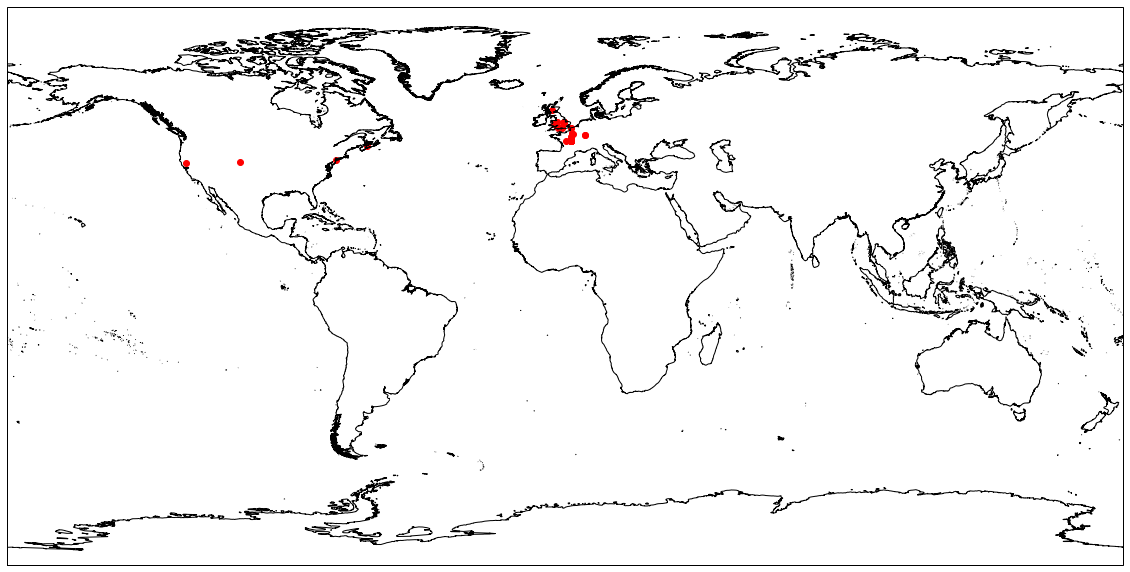

In [31]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree()) # choosing a Plate Carree map projection as our base
# ax.stock_img()
ax.coastlines(resolution='10m') # picking the highest resolution coastlines to show
ax.set_global()

for lon, lat in place_coord:
    plt.scatter(lon, lat, color='red', transform=ccrs.PlateCarree())

plt.show()

Success! Our map (a [Plate Carree](https://en.wikipedia.org/wiki/Equirectangular_projection) projection) now has each of the 48 locations found in our 47-volume adventure novel workset plotted. We can experiment with different views by choosing a different projection, changing the color/resolution of certain parameters, or by disabling others. For instance, what do you think happens if you comment out (to do so, use `command` + `/` while the text is highlighted), the `ax.set_global()` line? Were your expectations right? What do you think will happen if we do the same with `ax.stock_img()`?

As mentioned earlier, Cartopy has a lot of built-in options to produce different types of map graphics in python. Below are some of the ones I found interesting, but more can be found in the Cartopy documentation linked at the top of the notebook.

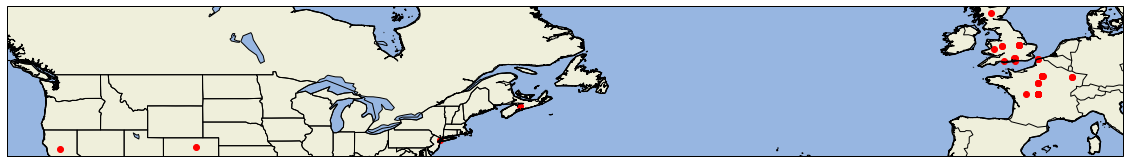

In [42]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
# ax.stock_img()
ax.coastlines(resolution='10m')
# ax.set_global()

for lon, lat in place_coord:
    plt.scatter(lon, lat, color='red', transform=ccrs.PlateCarree())

# Cartopy allows you to download non-standard datasets from Natural Earth (http://www.naturalearthdata.com/) 
# to include in our plot, such as the highest resolution representation of rivers:

rivers_10m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m')

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black')
# ax.add_feature(rivers_10m, facecolor='none', edgecolor='b')
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

plt.show()

## Replicating this process for full text data

To reproduce this process and output without a list or CSV of entities already in hand, we can use the [Natural Language Toolkit (NLTK)](https://www.nltk.org/), which runs best over full text documents. However, we must first also pre-process our text to give the best chance for accurate NER. In this instance, we're going to tokenize and tag each token with a part of speech.

In [10]:
import nltk

sample_string = 'I live in Champaign, but I often travel to Chicago, Istanbul, and London.'
words = nltk.word_tokenize(sample_string)
tagged = nltk.pos_tag(words)
print(tagged)

[('I', 'PRP'), ('live', 'VBP'), ('in', 'IN'), ('Champaign', 'NNP'), (',', ','), ('but', 'CC'), ('I', 'PRP'), ('often', 'RB'), ('travel', 'VBP'), ('to', 'TO'), ('Chicago', 'NNP'), (',', ','), ('Istanbul', 'NNP'), (',', ','), ('and', 'CC'), ('London', 'NNP'), ('.', '.')]


We can see now that we have a list with our tokens and their part-of-speech (POS) tags (which are based on the [Penn Treebank POS tags](https://www.clips.ua.ac.be/pages/mbsp-tags)), which can be fed directly into NLTK's built-in named entity classifier, `nltk.ne_chunk()`:

In [11]:
sample_chunked = nltk.ne_chunk(tagged)
# sample_chunked.draw()
print(sample_chunked)
print(type(sample_chunked))

(S
  I/PRP
  live/VBP
  in/IN
  (GPE Champaign/NNP)
  ,/,
  but/CC
  I/PRP
  often/RB
  travel/VBP
  to/TO
  (GPE Chicago/NNP)
  ,/,
  (GPE Istanbul/NNP)
  ,/,
  and/CC
  (GPE London/NNP)
  ./.)
<class 'nltk.tree.Tree'>


Above, you can see the actual named entities that the classifier is tagging, as well as the type of the output object: `<class 'nltk.tree.Tree'>` which you can probably tell is an NLTK Tree. If you'd like to see the drawn tree, you can un-comment the print statement in the above code, and the tree will be drawn in a new, pop-up window.

This type of object is specific to NLTK, so we'll need to think about how we can take the tree of entities and end up with a list of the desired class of entities we'd like, here roughly defined as place names. In order to extrsact locations, a less granular entity tag than NLTK uses, we'll need to write a function to identify the items in an NLTK tree with the type 'GPE' (geo-political entity) or 'ORGANIZATION' (or other tags, as appropriate). This function takes an NLTK Tree object as input, which minimzes steps in finding the entities we're interested in:

In [16]:
# The code here is adapted from Ted Underwood, who himself worked off a Stack Overflow answer by alvas:
# http://stackoverflow.com/questions/31836058/nltk-named-entity-recognition-to-a-python-list

def get_placenames(parsed_tree):
    prev = None
    continuous_chunk = []
    current_chunk = []
    for node in parsed_tree:
        if type(node) == nltk.Tree and (node.label() == "GPE" or node.label() == 'ORGANIZATION'):
            current_chunk.append(" ".join([token for token, pos in node.leaves()]))
        elif current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue
    return continuous_chunk

print(get_placenames(sample_chunked))

['Champaign', 'Chicago', 'Istanbul', 'London']


I'd encourage you to go through the function and see if you can identify what is happening at each step, but roughly, this function takes a parsed NLTK tree as an input, and then navigates through each node on the tree looking for entities with labels of a given type that we are defining (line 9), here `GPE` or `ORGANIZATION` which can both be used for locations (though remember that *all* tags are <100% reliable, since they are generated using trained classifiers).

Now that we habve a function that will find and extract particular types of entities from an NLTK tree, we can test it out on a block of text, here an excerpt from Herman Melville's *Moby Dick*, which nicely lends itself to NER:

In [17]:
text = ' '.join(["I stuffed a shirt or two into my old carpet-bag, tucked it ",
        "under my arm, and started for Cape Horn and the Pacific. Quitting ",
        "the good city of old Manhatto, I duly arrived in New Bedford. ",
        "It was a Saturday night in December. Much was I disappointed ",
        "upon learning that the little packet for Nantucket had already sailed, ",
        "and that no way of reaching that place would offer, till the following ",
        "Monday. As most young candidates for the pains and penalties of whaling ",
        "stop at this same New Bedford, thence to embark on their voyage, it may ",
        "as well be related that I, for one, had no idea of so doing. For ",
        "my mind was made up to sail in no other than a Nantucket craft, ",
        "because there was a fine, boisterous something about everything ",
        "connected with that famous old island, which amazingly pleased me. ",
        "Besides though New Bedford has of late been gradually monopolising ",
        "the business of whaling, and though in this matter poor old Nantucket ",
        "is now much behind her, yet Nantucket was her great original - the Tyre ",
        "of this Carthage;—the place where the first dead American whale was ",
        "stranded. Where else but from Nantucket did those aboriginal whalemen, ",
        "the Red-Men, first sally out in canoes to give chase to the Leviathan? ",
        "And where but from Nantucket, too, did that first adventurous little sloop ",
        "put forth, partly laden with imported cobblestones - so goes the story - ",
        "to throw at the whales, in order to discover when they were nigh enough ",
        "to risk a harpoon from the bowsprit?"])

sentences = nltk.sent_tokenize(text)

# Though it's a bit counterintuitive, given that we join the lines above into one chunk of text, before we 
# proceed to word_tokenize, we break the block of text into a list of sentences. The tagging and chunking 
# processes tend to work better on strings that are single sentences.

# Then we loop through the sentences, tagging and chunking each one, extracting placenames, and adding those 
# to a growing list of moby_places. Note that "extend" is like "append" but appends all the elements of a list 
# rather than a single one, which is useful for this task since we have potentially multiple entities we're
# interested in for each chunk.

moby_places = []

for s in sentences:
    words = nltk.word_tokenize(s)
    tagged = nltk.pos_tag(words)
    namedEnt = nltk.ne_chunk(tagged)
    chunks = get_placenames(namedEnt)
    moby_places.extend(chunks)

print('\nPLACENAMES: ')
print(moby_places)


PLACENAMES: 
['Pacific', 'New Bedford', 'New Bedford', 'New Bedford', 'Tyre', 'Carthage', 'American', 'Leviathan', 'Nantucket']


Success! Well, sort of. See anything strange with the above place names? This is a good time to add another friendly reminder that classifiers *will* make mistakes!

With a list of place names, we can now pick up a similar workflow to the one demonstrated with the HTRC NER output file, and geocode our locations by name using Geopy. This step should look familiar!:

In [18]:
allcoordinates = []

for placename in moby_places:
    time.sleep(1)
    try:
        fullname, (lat, lng) = api.geocode(placename)
        print(placename + ":  " + fullname)
        print(lat, lng)
        allcoordinates.append((lng, lat))
    except:
        print('Could not find: ' + placename)

Pacific:  Pacific County, Washington, USA
46.5334929 -123.768029
New Bedford:  New Bedford, Bristol County, Massachusetts, USA
41.6362152 -70.934205
New Bedford:  New Bedford, Bristol County, Massachusetts, USA
41.6362152 -70.934205
New Bedford:  New Bedford, Bristol County, Massachusetts, USA
41.6362152 -70.934205
Tyre:  صور, قضاء صور, محافظة الجنوب, 1601, لبنان
33.2721211 35.1964023
Carthage:  قرطاج, قرطاج الشاطئ, قرطاج, تونس, 2016, تونس
36.851627 10.330441
American:  The American, Baltimore, Maryland, USA
39.27982875 -76.5634629397454
Leviathan:  Leviathan, Inverell, NSW, Australia
-29.8316667 151.0677778
Nantucket:  Nantucket County, Massachusetts, United States of America
41.2657181 -70.0683144


Above, we see Geopy's best guess as to what each place name is referring to. Any strange or unexpected results?

We can also pilot this process for a sample sentence, here the same sentence we used in our first cell in this section to generate POS tags to feed into NLTK. Feel free to modify the sentence and see what the results look like. Are all of the locations found? Any unexpcted results? If so, any ideas why?

In [19]:
# We can also try this for our sample sentence:

sample_sentences = ['I live in Champaign, but I often travel to Chicago, Istanbul, and London.']
sample_places = []

for s in sample_sentences:
    words = nltk.word_tokenize(s)
    tagged = nltk.pos_tag(words)
    # print(tagged)
    namedEnt = nltk.ne_chunk(tagged)
    # print(namedEnt)
    chunks = get_placenames(namedEnt)
    sample_places.extend(chunks)
    
print(sample_places)

sample_coord = []

for placename in sample_places:
    time.sleep(1)
    try:
        fullname, (lat, lng) = api.geocode(placename)
        print(placename + ":  " + fullname)
        print(lat, lng)
        sample_coord.append((lng, lat))
    except:
        print('Could not find: ' + placename)
        
print(sample_coord)

['Champaign', 'Chicago', 'Istanbul', 'London']
Champaign:  Champaign, Champaign County, Illinois, USA
40.1164205 -88.2433829
Chicago:  Chicago, Cook County, Illinois, United States of America
41.8755616 -87.6244212
Istanbul:  İstanbul, Fatih, İstanbul, Marmara Bölgesi, 34126, Türkiye
41.0096334 28.9651646
London:  London, Greater London, England, SW1A 2DX, United Kingdom
51.5073219 -0.1276474
[(-88.2433829, 40.1164205), (-87.6244212, 41.8755616), (28.9651646, 41.0096334), (-0.1276474, 51.5073219)]


Once again, with a list of place names and coordinates, we can call on our old electronic friend Cartopy to generate a map and plot the locations:

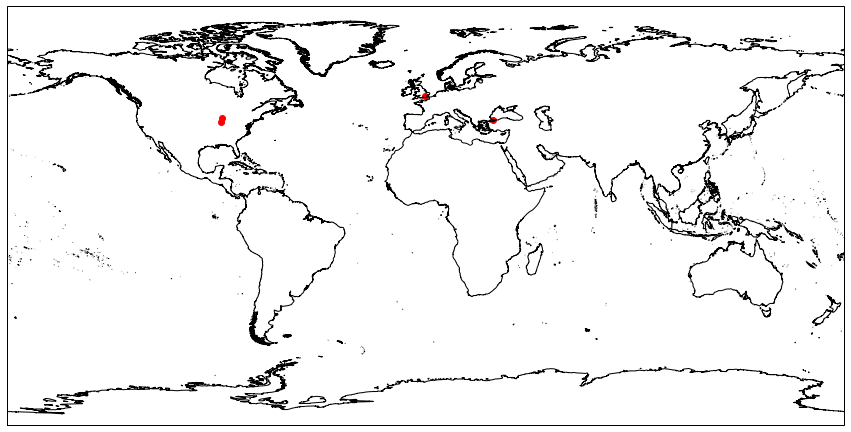

In [20]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
# ax.stock_img()
ax.coastlines(resolution='10m')
ax.set_global()

for lon, lat in sample_coord:
    plt.scatter(lon, lat, color='red', transform=ccrs.PlateCarree())
    
plt.show()

Success, and this time without the "sort of!"

If you want to try again or want to explore some of the options with Cartopy (check out the [Cartopy documentation](https://scitools.org.uk/cartopy/docs/latest/index.html) for more information on the full set of features and functionality), try out geocoding and plotting other locations. Here is another example using a list of English Premier League team stadia:

In [21]:
# try substituting other locations in this list and see what results you get!

pl_stadia = ['Anfield', 'Goodison Park', 'Old Trafford', 'City of Manchester Stadium', 'Carrow Road', 
             'Bramall Lane','Emirates Stadium','Stamford Bridge', 'London Stadium', "St. James' Park",
             'Dean Court', 'Falmer Stadium', 'King Power Stadium', 'Molineux Stadium', "Southampton FC",
             'Selhurst Park', 'Tottenham Hotspur Stadium', 'Turf Moor', 'Vicarage Road', 'Villa Park']

pl_coord = []

for placename in pl_stadia:
    time.sleep(1)
    try:
        fullname, (lat, lng) = api.geocode(placename)
        print(placename + ":  " + fullname)
        print(lat, lng)
        pl_coord.append((lng, lat))
    except:
        print('Could not find: ' + placename)

Anfield:  Anfield, Anfield Road, Walton, Liverpool, North West England, England, L4 0TH, UK
53.4308358 -2.96090954141653
Goodison Park:  Goodison Park, Goodison Road, Walton, Liverpool, North West England, England, L4 4EL, UK
53.4387191 -2.96645399390874
Old Trafford:  Old Trafford, Munich Tunnel, Wharfside, Trafford, Greater Manchester, North West England, England, M16 0RA, UK
53.46310955 -2.29138648505454
City of Manchester Stadium:  Etihad Stadium, Joe Mercer Way, Beswick, Manchester, Greater Manchester, North West England, England, M11 3FF, UK
53.48309105 -2.20025200234333
Carrow Road:  Carrow Road, Lakenham, Norwich, Norfolk, East of England, England, NR1 2BT, UK
52.6214386 1.3067458
Bramall Lane:  Bramall Lane, Moorfoot, Highfield, Sheffield, Yorkshire and the Humber, England, S2 4FQ, UK
53.3720415 -1.4726317
Emirates Stadium:  Emirates Stadium, 75, Drayton Park, Finsbury Park, London Borough of Islington, London, Greater London, England, N5 1BU, UK
51.55504035 -0.108399670867237

Since we know a bit more about our data this time, we can try out a few of Cartopy's advanced features:

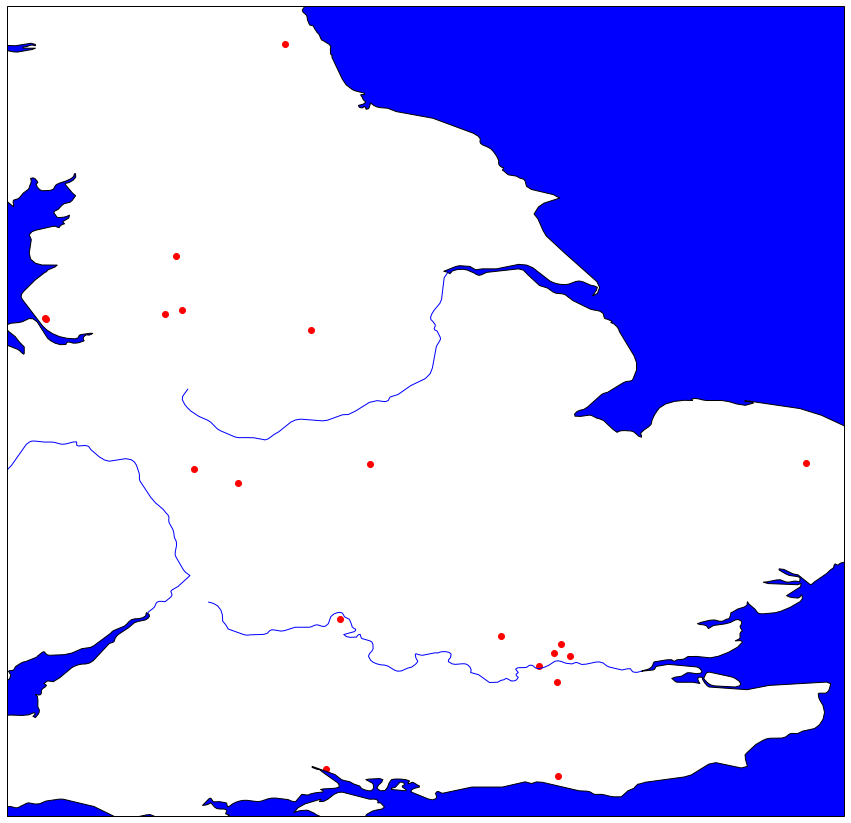

In [86]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
# ax.stock_img()
# ax.set_global()

for lon, lat in pl_coord:
    plt.scatter(lon, lat, color='red', alpha=1, transform=ccrs.PlateCarree())

    
rivers_10m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m')
ocean_10m = cfeature.NaturalEarthFeature('physical', 'ocean', '10m')
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m')

ax.add_feature(ocean_10m, facecolor='blue')
ax.add_feature(land_10m, edgecolor = 'black', facecolor='none')
ax.add_feature(rivers_10m, facecolor='none', edgecolor='blue')
ax.add_feature(cfeature.BORDERS)

plt.show()

More information on available features is available at the previously linked Cartopy documentation. Cartopy has some built-in support for a few external feature sources as well, including [Natural Earth](https://www.naturalearthdata.com/) features.